In [5]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
#显示所有列
pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', None)
#设置value的显示长度为100，默认为50
pd.set_option('max_colwidth',100)

In [6]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [7]:
data = pd.read_csv('data1.csv', sep=',')
data = reduce_mem_usage(data)

Memory usage of dataframe is 553928.00 MB
Memory usage after optimization is: 147028.00 MB
Decreased by 73.5%


In [8]:
top50_name = ['x77','x68','x239','x30','x345','x258','x37','x226','x128','x244','x33','x61','x306','x26','x2','x46','x274','x12','x74','x79','x6','x28','x54','x184','x60','x312','x162','x320','x315','x245','x273','x219','x314','x307','x191','x169','x52','x164','x240','x130','x195','x182','x317','x123','x51','x310','x194','x4','x174','x16']

In [9]:
X = data[top50_name]
Y = data['y']

best combination (r2: 0.070): (3, 8, 11, 12, 27, 31, 46, 47)

all subsets:
 {1: {'feature_idx': (27,), 'cv_scores': array([-0.00096039, -0.00657861,  0.1179125 , -0.11331175, -0.01907068]), 'avg_score': -0.004401787679155311, 'feature_names': ('x320',)}, 2: {'feature_idx': (11, 27), 'cv_scores': array([ 0.02911822, -0.02355921,  0.15975785, -0.00726034,  0.03068811]), 'avg_score': 0.03774892517381725, 'feature_names': ('x61', 'x320')}, 3: {'feature_idx': (3, 11, 27), 'cv_scores': array([0.00357327, 0.0218758 , 0.15077085, 0.0870653 , 0.04163954]), 'avg_score': 0.060984952505680076, 'feature_names': ('x30', 'x61', 'x320')}, 4: {'feature_idx': (3, 8, 11, 27), 'cv_scores': array([0.01715579, 0.03589154, 0.15050638, 0.08602284, 0.02521513]), 'avg_score': 0.06295833655415654, 'feature_names': ('x30', 'x128', 'x61', 'x320')}, 5: {'feature_idx': (3, 8, 11, 12, 27), 'cv_scores': array([-0.01718467,  0.04739789,  0.1600026 ,  0.09534973,  0.04186308]), 'avg_score': 0.06548572565142223, 'feature

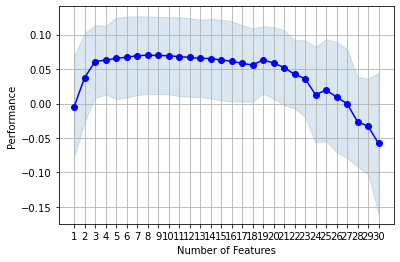

In [24]:
from sklearn.ensemble import RandomForestRegressor
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.linear_model import LinearRegression, Ridge
sfs1 = SFS(Ridge(), 
           k_features=(1, 30),
           forward=True, 
           floating=False, 
           scoring='r2',
           cv=5,
           n_jobs=-1)

sfs1.fit(X, Y, custom_feature_names=top50_name)

print('best combination (r2: %.3f): %s\n' % (sfs1.k_score_, sfs1.k_feature_idx_))
print('all subsets:\n', sfs1.subsets_)
plot_sfs(sfs1.get_metric_dict(), kind='std_dev')
plt.grid()
plt.show()

In [25]:
linertop_name = ['x30', 'x128', 'x61', 'x306', 'x320', 'x219', 'x194', 'x4']

In [26]:
liner = Ridge()
liner.fit(X[linertop_name], Y)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [27]:
liner.coef_, liner.intercept_

(array([ 0.01922786,  0.0372182 ,  0.01491745,  0.02600203, -0.00051085,
        -0.00158049, -0.01866962, -0.00289908]),
 -4.762845786531116)

In [28]:
y_liner_pred = liner.predict(X[linertop_name])

In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score

In [30]:
mean_squared_error(y_liner_pred, Y), r2_score(y_liner_pred, Y)

(0.04152920121675289, -3.45038112695591)

best combination (r2: 0.105): (0, 3, 10, 11, 13, 14, 16, 20, 21, 22, 26, 27, 28, 29, 30, 34, 35, 39, 41, 42, 43, 47, 48, 49)

all subsets:
 {1: {'feature_idx': (27,), 'cv_scores': array([-1.49661105e-04, -5.07660532e-03,  1.23955657e-01, -6.71211797e-01,
        3.86072743e-02]), 'avg_score': -0.10277502638660156, 'feature_names': ('x320',)}, 2: {'feature_idx': (27, 42), 'cv_scores': array([-1.49755782e-04, -5.07660532e-03,  1.04882419e-01, -7.17228420e-01,
       -7.46361698e-02]), 'avg_score': -0.13844170650964138, 'feature_names': ('x320', 'x317')}, 3: {'feature_idx': (27, 42, 48), 'cv_scores': array([-1.49793330e-04, -5.08230761e-03,  1.53207654e-02, -3.49913602e-01,
       -7.50278435e-02]), 'avg_score': -0.0829705563105712, 'feature_names': ('x320', 'x317', 'x174')}, 4: {'feature_idx': (21, 27, 42, 48), 'cv_scores': array([-0.06918565, -0.18111469, -0.01145476, -0.35183893, -0.03285959]), 'avg_score': -0.12929072470051808, 'feature_names': ('x28', 'x320', 'x317', 'x174')}, 5: {'f

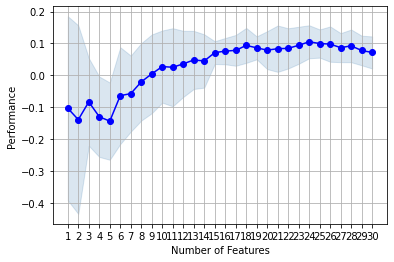

In [33]:
from sklearn.ensemble import RandomForestRegressor
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
regr = RandomForestRegressor(max_depth=10, random_state=0)
sfs1 = SFS(regr, 
           k_features=(15, 30),
           forward=True, 
           floating=False, 
           scoring='r2',
           cv=5,
           n_jobs=-1)

sfs1.fit(X, Y, custom_feature_names=top50_name)

print('best combination (r2: %.3f): %s\n' % (sfs1.k_score_, sfs1.k_feature_idx_))
print('all subsets:\n', sfs1.subsets_)
plot_sfs(sfs1.get_metric_dict(), kind='std_dev')
plt.grid()
plt.show()

In [35]:
endl_name = ['x77', 'x30', 'x33', 'x61', 'x26', 'x2', 'x274', 'x6', 'x28', 'x54', 'x162', 'x320', 'x315', 'x245', 'x273', 'x191', 'x169', 'x130', 'x182', 'x317', 'x123', 'x4', 'x174', 'x16']

In [67]:
X = data[endl_name]

In [68]:
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.linear_model import SGDRegressor, Lasso, Ridge
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
from sklearn.ensemble import RandomForestRegressor as rf
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
warnings.filterwarnings('ignore')

In [69]:
def single_model(clf, X, Y, clf_name, class_num=1):
    train = np.zeros((X.shape[0], class_num))

    if clf_name in ['sgd', 'ridge', "lasso"]:
        print('MinMaxScaler...')
        for col in endl_name:
            ss = MinMaxScaler()
            ss.fit(X[[col]].values)
            X[col] = ss.transform(X[[col]].values).flatten()

    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)


    if clf_name == "lgb":
        train_matrix = clf.Dataset(x_train, label=y_train)
        valid_matrix = clf.Dataset(x_test, label=y_test)
        data_matrix = clf.Dataset(X, label=Y)

        params = {
            'boosting_type': 'gbdt',
            'objective': 'mse',
            'min_child_weight': 5,
            'num_leaves': 2 ** 8,
            'feature_fraction': 0.5,
            'bagging_fraction': 0.5,
            'bagging_freq': 1,
            'learning_rate': 0.001,
            'seed': 2020
        }

        model = clf.train(params, train_matrix, 50000, valid_sets=[train_matrix, valid_matrix], verbose_eval=500,
                          early_stopping_rounds=1000)
        model2 = clf.train(params, data_matrix, model.best_iteration)
        val_pred = model.predict(x_test, num_iteration=model2.best_iteration).reshape(-1, 1)
        y_pred = model.predict(X, num_iteration=model2.best_iteration).reshape(-1, 1)
        # test_pred = model.predict(test_x, num_iteration=model2.best_iteration).reshape(-1, 1)

    if clf_name == "xgb":
        train_matrix = clf.DMatrix(x_train, label=y_train, missing=np.nan)
        valid_matrix = clf.DMatrix(x_test, label=y_test, missing=np.nan)
        data_matrix = clf.DMatrix(X, label=Y)
        # test_matrix = clf.DMatrix(test_x, label=y_test, missing=np.nan)
        params = {'booster': 'gbtree',
                  'n_estimators' : 1,
                  'eval_metric': 'mae',
                  'min_child_weight': 5,
                  'max_depth': 5,
                  'subsample': 0.8041,
                  'colsample_bytree': 0.9289,
                  'eta': 0.001,
                  'seed': 2020,
                  'nthread': 36,
                  'silent': True,
                  }

        watchlist = [(train_matrix, 'train'), (valid_matrix, 'eval')]

        model = clf.train(params, train_matrix, num_boost_round=50000, evals=watchlist, verbose_eval=500,
                          early_stopping_rounds=1000)
        val_pred = model.predict(valid_matrix, ntree_limit=model.best_ntree_limit).reshape(-1, 1)
        y_pred = model.predict(data_matrix, ntree_limit=model.best_ntree_limit).reshape(-1, 1)

    if clf_name == "cat":
        params = {'learning_rate': 0.001, 'depth': 5, 'l2_leaf_reg': 10, 'bootstrap_type': 'Bernoulli',
                  'od_type': 'Iter', 'od_wait': 50, 'random_seed': 11, 'allow_writing_files': False}

        model = clf(iterations=20000, **params)
        model.fit(x_train, y_train, eval_set=(x_test, y_test),
                  cat_features=[], use_best_model=True, verbose=500)

        val_pred = model.predict(x_test)
        # test_pred = model.predict(test_x)

    if clf_name == 'rf':
        params = {
            "max_depth": 9,
            "max_features": 0.4717,
            'min_samples_split': 15,
            'n_estimators': 36
        }
        model = clf(**params)
        model.fit(x_train, y_train)
        val_pred = model.predict(x_test)
        y_pred = model.predict(X)


    if clf_name == "sgd":
        params = {
            'loss': 'squared_loss',
            'penalty': 'l2',
            'alpha': 0.00001,
            'random_state': 2020,
        }
        model = SGDRegressor(**params)
        model.fit(x_train, y_train)
        val_pred = model.predict(x_test)
        y_pred = model.predict(X)

    if clf_name == "ridge":
        params = {
            'alpha': 1.0,
            'random_state': 2020,
        }
        model = Ridge(**params)
        model.fit(x_train, y_train)
        val_pred = model.predict(x_test)
        y_pred = model.predict(X)
        
    if clf_name == "lasso":
        model = Lasso(alpha=0.1)
        model.fit(x_train, y_train)
        val_pred = model.predict(x_test)
        y_pred = model.predict(X)
        
    if clf_name == "SVR":
        model = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
        model.fit(x_train, y_train)
        val_pred = model.predict(x_test)
        y_pred = model.predict(X)
        
    print("%s_mse_score:" % clf_name, mean_squared_error(y_test, val_pred))

    return val_pred, mean_squared_error(y_test, val_pred), y_pred


def lgb_model(x, y):
    lgb_test, lgb_mse, y_pred = single_model(lgb, x, y, "lgb")
    return lgb_test, lgb_mse, y_pred

def lasso_model(x, y):
    lasso_test, lasso_mse, lasso_y = single_model(Lasso, x, y, "lasso")
    return lasso_test, lasso_mse, lasso_y

def SVR_model(x, y):
    svr_test, svr_mse, svr_y = single_model(SVR, x, y, "SVR")
    return svr_test, svr_mse, svr_y

def rf_model(x, y,):
    rf_test, rf_mse, y_pred = single_model(rf, x, y,'rf')
    return rf_test, rf_mse, y_pred

def xgb_model(x, y):
    xgb_test, xgb_mse, y_pred = single_model(xgb, x, y, "xgb")
    return xgb_test, xgb_mse, y_pred


def cat_model(x, y):
    cat_test, cat_mse = single_model(CatBoostRegressor, x, y, "cat")
    return cat_test, cat_mse


def sgd_model(x, y,):
    sgd_test, sgd_mse, y_pred = single_model(SGDRegressor, x, y, "sgd")
    return sgd_test, sgd_mse, y_pred


def ridge_model(x, y):
    ridge_test, ridge_mse, y_pred = single_model(Ridge, x, y, "ridge")
    return ridge_test, ridge_mse, y_pred

rf_test, rf_mse, y_rf = rf_model(X, Y)

ridge_test, ridge_mse, y_ridge  = ridge_model(X, Y)

sgd_test, sgd_mse, y_sgd = sgd_model(X, Y)

lgb_test, lgb_mse, y_lgd = lgb_model(X, Y)

xgb_test, xgb_mse, y_xgb = xgb_model(X, Y)

lasso_test, lasso_mse, y_lasso = lasso_model(X, Y)

svr_test, svr_mse, y_svr = SVR_model(X, Y) 

rf_mse_score: 0.03862037990264291
MinMaxScaler...
ridge_mse_score: 0.037788573244418866
MinMaxScaler...
sgd_mse_score: 0.0437780664617148
Training until validation scores don't improve for 1000 rounds
[500]	training's l2: 0.0441986	valid_1's l2: 0.0452278
[1000]	training's l2: 0.0401288	valid_1's l2: 0.0429023
[1500]	training's l2: 0.0373195	valid_1's l2: 0.0417768
[2000]	training's l2: 0.0351906	valid_1's l2: 0.0413006
[2500]	training's l2: 0.0334373	valid_1's l2: 0.0409075
[3000]	training's l2: 0.0319604	valid_1's l2: 0.0408209
[3500]	training's l2: 0.0306057	valid_1's l2: 0.0407532
[4000]	training's l2: 0.0294022	valid_1's l2: 0.0407776
Early stopping, best iteration is:
[3299]	training's l2: 0.0311308	valid_1's l2: 0.0407011
lgb_mse_score: 0.040701141766917
[0]	train-mae:0.75204	eval-mae:0.76594
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 1000 rounds.
[500]	train-mae:0.46667	eval-mae:0.47744
[1000

In [66]:
print(rf_mse, ridge_mse, sgd_mse, lgb_mse, xgb_mse, svr_mse, lasso_mse)

0.04114336709949009 0.03778789529612342 0.0437780664617148 0.040701141766917 0.039892815 0.05027010218187939 0.05031743440372587


In [50]:
print(rf_mse, ridge_mse, sgd_mse, lgb_mse, xgb_mse)

0.0406564853358256 0.03778789529612342 0.0437780664617148 0.040701141766917 0.039892815


In [52]:
print(rf_mse, ridge_mse, sgd_mse, lgb_mse, xgb_mse)

0.040996289358658594 0.03778789529612342 0.0437780664617148 0.040701141766917 0.039892815


In [53]:
from sklearn.metrics import r2_score
r2_score(Y, y_ridge)

0.24349211388885106